# Logistic Regression Model

We created a logistic regression model trained on our preprocessed data. In this notebook, you can find how we addressed the issue of unbalanced classification and our feature engineering efforts.

We had to create several models to reach the final model. We explained it in terms of statistical results and business interpretation of regression coefficients.

We presented results on both **TESTING AND TRAINING DATASETS** such as:

- Performance metrics: Accuracy, Precision, Recall, and F1 score for both Testing and Training samples.
- ROC curve (AUC) and an explanation of the discriminatory power of the model in both Testing and Training samples.

We showcased these towards the end.

**For comparing non-final models, we utilized only a subset of the mentioned metrics as they were deemed sufficient.**

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()[:-18])
from source.eda_utils import get_dataFrame_withShortCols, data_cleaner, preprocess_data
from source.ml_utils import calculate_non_correlated_features, print_results, plot_roc, get_reduced_data
import seaborn as snus
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


In [2]:
# preprocessed data 
train_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('development_sample.csv')))
val_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('testing_sample.csv')))

c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\eda_utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_0'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasification of the vehicle'] == 0)).astype(int)
c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\eda_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_1'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasific

## Old Model 

Since we were unsure about the meaning of the column r and couldn't find a definitive answer online, we assumed it represents predictions from an old model. However, we are not certain, and these are only our assumptions. We will not use it later for training our models.

In [3]:
cm_r = confusion_matrix(train_data['Default indicator'], (train_data['_r_'] > 0.5).astype(int))
accuracy_r = accuracy_score(train_data['Default indicator'], (train_data['_r_'] > 0.5).astype(int))
cm_r, accuracy_r


(array([[17294, 17003],
        [  533,   562]], dtype=int64),
 0.5045207956600362)

In [4]:
cm_r = confusion_matrix(val_data['Default indicator'], (val_data['_r_'] > 0.5).astype(int))
accuracy_r = accuracy_score(val_data['Default indicator'], (val_data['_r_'] > 0.5).astype(int))
cm_r, accuracy_r

(array([[1724, 1703],
        [  61,   58]], dtype=int64),
 0.5025380710659898)

This model performed poorly.

## Benchmark Model

The first step in our modeling process was to create a benchmark model, which serves as a reference to assess whether the model tuning process was worthwhile. 


We decided not to consider the 'Application date' data as it would be challenging to train a model on it. We thought about not dividing the dates into categories or quarters and using one-hot encoding, but this would further increase the number of variables in our dataframe. It is worth emphasizing that the model takes into account the difference between 'Application date' and 'employment date' that we created.

In [3]:
X_train = train_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_train = train_data['Default indicator']

X_val = val_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_val = val_data['Default indicator']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [4]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
logit_result = logit_model.fit(maxiter=1000)


y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)
# accuracy and confusion matrix
print_results(y_val, y_pred)

Optimization terminated successfully.
         Current function value: 0.114605
         Iterations 9
Accuracy: 0.9670050761421319
Confusion Matrix:
[[3427    0]
 [ 117    2]]


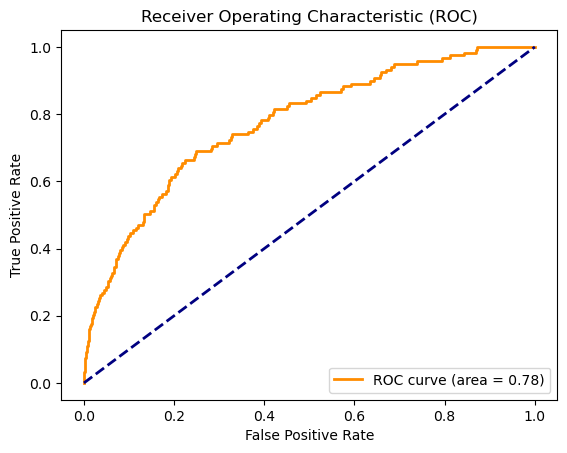

In [34]:
# roc curve
fpr, tpr, thresholds = roc_curve(y_val, logit_result.predict(sm.add_constant(X_val_scaled)))
plot_roc(fpr, tpr)

On the test data, the model correctly identifies individuals without defaults (3427), but performs significantly worse for those who defaulted (2). It achieves a mere 0.78 AUC, indicating some room for improvement. Since the model poorly identifies individuals who fail to repay their loans, it is suboptimal for the bank's purposes. It is only marginally better than simply assuming that every individual will repay the loan.

## Over sampling

The first step towards improving the results was oversampling individuals with defaults. This approach aims to create a model that places greater emphasis on identifying individuals who defaulted.

In [5]:
smot = SMOTE(sampling_strategy=0.3, random_state=42)

oversampled_X, oversampled_Y = smot.fit_resample(X_train_scaled, y_train)
readyDF = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
readyDF['Default indicator'].value_counts()


Default indicator
0.0    34297
1.0    10289
Name: count, dtype: int64

In [6]:
logit_model = sm.Logit(oversampled_Y, sm.add_constant(oversampled_X))
logit_result = logit_model.fit(maxiter=1000)

y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)
print_results(y_val, y_pred)

Optimization terminated successfully.
         Current function value: 0.422630
         Iterations 9
Accuracy: 0.9402143260011281
Confusion Matrix:
[[3305  122]
 [  90   29]]


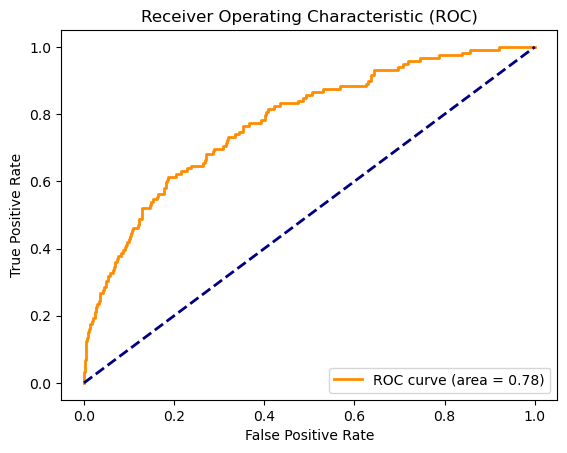

In [7]:
fpr, tpr, thresholds = roc_curve(y_val, logit_result.predict(sm.add_constant(X_val_scaled)))
plot_roc(fpr, tpr)

Oversampling with a typical 0.3 minority class sampling strategy yielded improved results (AUC=0.78). It has satisfactory specificity, but sensitivity is significantly lower. However, we believe further optimization can be achieved by increasing the minority class even more.

In [8]:
smot = SMOTE(sampling_strategy=1, random_state=42)
oversampled_X, oversampled_Y = smot.fit_resample(X_train_scaled, y_train)
readyDF = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
readyDF['Default indicator'].value_counts()

Default indicator
0.0    34297
1.0    34297
Name: count, dtype: int64

In [9]:
logit_model = sm.Logit(oversampled_Y, sm.add_constant(oversampled_X))
logit_result = logit_model.fit(maxiter=1000)

y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)
print_results(y_val, y_pred)

Optimization terminated successfully.
         Current function value: 0.532936
         Iterations 9
Accuracy: 0.7560631697687535
Confusion Matrix:
[[2603  824]
 [  41   78]]


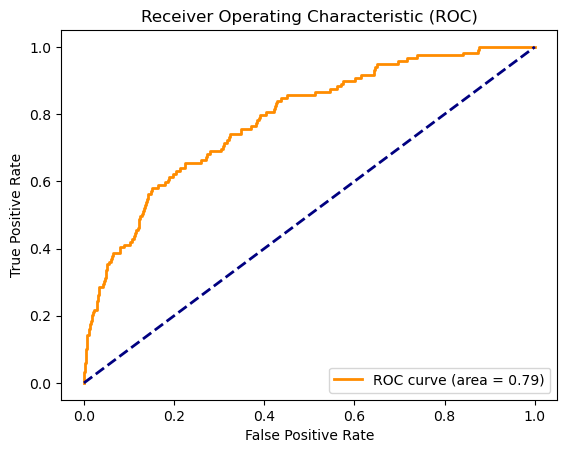

In [10]:
fpr, tpr, thresholds = roc_curve(y_val, logit_result.predict(sm.add_constant(X_val_scaled)))
plot_roc(fpr, tpr)

In [11]:
# coeficients, p values 
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Default indicator   No. Observations:                68594
Model:                          Logit   Df Residuals:                    68546
Method:                           MLE   Df Model:                           47
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.2311
Time:                        18:51:05   Log-Likelihood:                -36556.
converged:                       True   LL-Null:                       -47546.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6168      0.010    -59.727      0.000      -0.637      -0.597
x1             0.0073      0.023      0.316      0.752      -0.038       0.052
x2             0.3207      0.035      9.147      0.000       0.252       0.389
x3            -0.0828      0.013     -6.551      0.000      -0.108      -0.058
x4             0.0330      0.020      1.622      0.105      -0.007       0.073
x5            -0.6066      0.034    -17.826      0.000      -0.673      -0.540
x6            -0.7170      0.026    -27.147      0.000      -0.769      -0.665
x7            -0.6464      0.029    -22.615      0.000      -0.702      -0.590
x8            -0.1985      0.018    -11.293      0.000      -0.233      -0.164
x9             0.0774      0.016      4.691      0.000       0.045       0.110
x10            1.4599      0.039     37.515      0.000       1.384       1.536
x11            0.0129      0.014      0.942      0.346      -0.014       0.040
x12           -0.0285      0.020     -1.408      0.159      -0.068       0.011
x13            0.1848      0.027      6.900      0.000       0.132       0.237
x14           -0.1166      0.022     -5.193      0.000      -0.161      -0.073
x15           -0.1565      0.011    -14.204      0.000      -0.178      -0.135
x16           -0.3178      0.013    -24.203      0.000      -0.344      -0.292
x17           -0.2714      0.013    -21.066      0.000      -0.297      -0.246
x18            0.0371      0.008      4.621      0.000       0.021       0.053
x19            0.3600      0.008     42.666      0.000       0.343       0.377
x20            0.3233      0.010     32.526      0.000       0.304       0.343
x21            0.0383      0.021      1.846      0.065      -0.002       0.079
x22            0.0011      0.010      0.111      0.912      -0.018       0.020
x23           -0.0906      0.016     -5.547      0.000      -0.123      -0.059
x24           -0.0280      0.023     -1.208      0.227      -0.073       0.017
x25           -0.0630      0.011     -5.702      0.000      -0.085      -0.041
x26           -0.5723      0.019    -30.520      0.000      -0.609      -0.536
x27           -0.0245      0.010     -2.398      0.016      -0.045      -0.004
x28           -0.0140      0.012     -1.182      0.237      -0.037       0.009
x29           -0.0489      0.012     -3.923      0.000      -0.073      -0.024
x30           -0.0870      0.016     -5.555      0.000      -0.118      -0.056
x31           -0.3630      0.015    -24.134      0.000      -0.392      -0.334
x32           -0.4249      0.016    -26.106      0.000      -0.457      -0.393
x33           -0.4975      0.020    -24.960      0.000      -0.537      -0.458
x34           -0.5044      0.025    -19.805      0.000      -0.554      -0.454
x35           -0.4331      0.018    -23.921      0.000      -0.469      -0.398
x36            0.0543      0.010      5.237      0.000       0.034       0.075
x37            0.0992      0.009     11.666      0.000       0.083       0.116
x3

Oversampling to balance the number of individuals with and without defaults ended with satisfactory results. The model correctly identifies 2608 individuals repaying the loan and 78 individuals defaulting, with an AUC of 79 We consider this a balanced approach (sensitivity and specifity trade-off), as further increasing the minority class would lead to the model being overly conservative and rejecting too many repaying customers.

## Model with reduced dimensions

Our next step was to reduce dimensions in our model. Our current model has a large number of columns, making it challenging to explain to others. Limiting dimensions will increase the business value of this model, making it much easier to explain what factors the model takes into account. The criterion we used to discard variables was their correlation. Variables with correlations above 0.6 and below -0.6 were discarded.

In [12]:
# get non correlated features from defined by us function
selected_features = calculate_non_correlated_features(X_train, 0.60)

In [13]:
len(selected_features)

33

In [14]:
# get reduced (and oversampled with minor_strategy=1) data
Xtrain, ytrain, Xval, yval = get_reduced_data(train_data, val_data, selected_features)

In [15]:
logit_model = sm.Logit(ytrain, sm.add_constant(Xtrain))
logit_result = logit_model.fit(maxiter=1000)

y_pred = (logit_result.predict(sm.add_constant(Xval)) > 0.5).astype(int)
print_results(yval, y_pred)


Optimization terminated successfully.
         Current function value: 0.551836
         Iterations 8
Accuracy: 0.7560631697687535
Confusion Matrix:
[[2604  823]
 [  42   77]]


The model now has slightly worse performance, but it's a minor loss considering that we managed to reduce the variables affecting predictions by 14 (30%).

In [22]:
# features
selected_features

['Credit duration',
 'Installment amount',
 'Spendings estimation',
 'Limit on credit card',
 'Amount on current account',
 'Amount on savings account',
 'Arrear in last 3 months',
 'Arrear in last 12 months',
 'Credit bureau score',
 'work experience',
 'loan_purpose_1_0',
 'loan_purpose_2_0',
 'loan_purpose_2_1',
 'Distribution channel_2',
 'Distribution channel_3',
 'Payment frequency_3',
 'Payment frequency_6',
 'profession of main applicant_2',
 'profession of main applicant_3',
 'profession of main applicant_4',
 'profession of main applicant_5',
 'profession of main applicant_6',
 'profession of main applicant_7',
 'profession of second applicant_1.0',
 'profession of second applicant_2.0',
 'profession of second applicant_3.0',
 'profession of second applicant_4.0',
 'profession of second applicant_6.0',
 'profession of second applicant_7.0',
 'marital status of main applicant_1',
 'marital status of main applicant_2',
 'marital status of main applicant_3',
 'marital status of 

## Final Model Results

In [17]:
y_train_pred = (logit_result.predict(sm.add_constant(Xtrain)) > 0.5).astype(int)
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred)
recall_train = recall_score(ytrain, y_train_pred)
f1_train = f1_score(ytrain, y_train_pred)

accuracy_val = accuracy_score(yval, y_pred)
precision_val = precision_score(yval, y_pred)
recall_val = recall_score(yval, y_pred)
f1_val = f1_score(yval, y_pred)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train],
    'Test': [accuracy_val, precision_val, recall_val, f1_val]
})

# summary datframe of model performance
metrics_df

,Metric,Train,Test
0,Accuracy,0.699682,0.756063
1,Precision,0.726314,0.085556
2,Recall,0.640843,0.647059
3,F1 Score,0.680907,0.151129


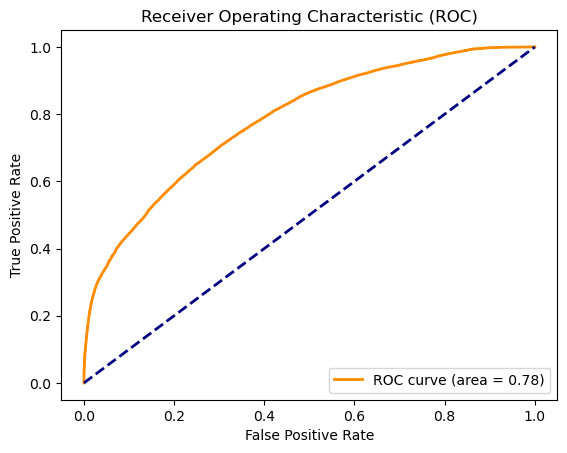

In [18]:
# roc curve on train data
fpr_train, tpr_train, thresholds_train = roc_curve(ytrain, logit_result.predict(sm.add_constant(Xtrain)))
plot_roc(fpr_train, tpr_train)

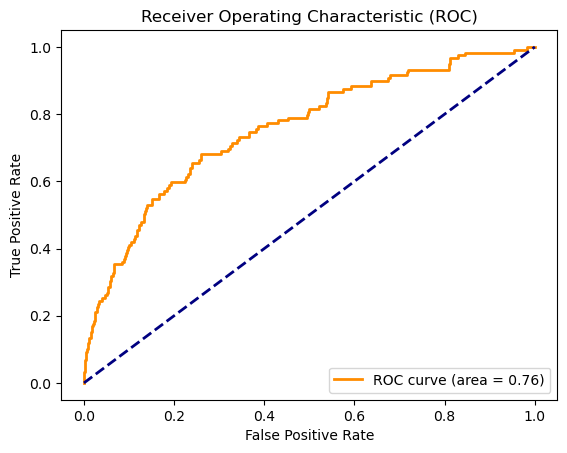

In [19]:
# roc curve on test data
fpr_test, tpr_test, thresholds_test = roc_curve(yval, logit_result.predict(sm.add_constant(Xval)))
plot_roc(fpr_test, tpr_test)

## Statistics and Business Interpretation of Coeficients

### Statistical Results:
In the table below, you can see the coefficients, standard errors, and p-values of individual variables. The estimation method used is Maximum Likelihood.
The Pseudo R-squared is 0.2039, suggesting that the model fits the data well.
The p-value for the LR test is 0.000, indicating that the model is statistically significant.
The constant coefficient (const) is -0.5356.
The coefficients of predictors x1, x2, ..., x33 (column names were replaced with x during scaling) determine the influence of each variable on the probability of default event. For example, the coefficient of x3 is 0.3554. A higher coefficient implies a stronger impact of the variable on the outcome, while a lower p-value suggests greater confidence in this relationship.

### Business Interpretation of Regression Coefficients
The coefficients in the table allow us to assess the influence of individual attributes on default risk. For instance lets look at the variable x8 from the table. With a coefficient of 0.3516 and a significant p-value, it suggests a strong positive impact on the default indicator. Higher values of x8 are associated with increased default risk. Understanding the impact of each variable on the probability of default, the bank can adjust its credit policy to minimize default risk and increase profitability. Coefficient analysis also helps identify key determinants of default, which can be useful for making business decisions regarding customer segmentation and marketing strategy.

In [20]:
# coeficients, p values 
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Default indicator   No. Observations:                68594
Model:                          Logit   Df Residuals:                    68560
Method:                           MLE   Df Model:                           33
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.2039
Time:                        18:59:34   Log-Likelihood:                -37853.
converged:                       True   LL-Null:                       -47546.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5356      0.010    -54.615      0.000      -0.555      -0.516
x1            -0.1882      0.011    -17.690      0.000      -0.209      -0.167
x2            -0.1065      0.017     -6.233      0.000      -0.140      -0.073
x3             0.3554      0.013     27.149      0.000       0.330       0.381
x4            -0.1654      0.011    -15.628      0.000      -0.186      -0.145
x5            -0.3437      0.012    -28.341      0.000      -0.367      -0.320
x6            -0.3109      0.012    -25.015      0.000      -0.335      -0.287
x7             0.0449      0.008      5.688      0.000       0.029       0.060
x8             0.3516      0.008     42.452      0.000       0.335       0.368
x9             0.3261      0.010     34.148      0.000       0.307       0.345
x10            0.0114      0.010      1.190      0.234      -0.007       0.030
x11           -0.1063      0.010    -10.877      0.000      -0.126      -0.087
x12            0.0770      0.008      9.582      0.000       0.061       0.093
x13           -0.3382      0.011    -30.666      0.000      -0.360      -0.317
x14           -0.0208      0.010     -2.118      0.034      -0.040      -0.002
x15            0.0319      0.010      3.278      0.001       0.013       0.051
x16            0.0253      0.011      2.243      0.025       0.003       0.048
x17            0.0126      0.014      0.912      0.362      -0.014       0.040
x18           -0.3208      0.014    -23.022      0.000      -0.348      -0.293
x19           -0.3801      0.015    -25.138      0.000      -0.410      -0.350
x20           -0.4795      0.019    -24.933      0.000      -0.517      -0.442
x21           -0.4984      0.025    -20.188      0.000      -0.547      -0.450
x22           -0.4128      0.018    -23.587      0.000      -0.447      -0.378
x23            0.1865      0.009     20.507      0.000       0.169       0.204
x24            0.0722      0.007     10.448      0.000       0.059       0.086
x25           -0.1064      0.011     -9.296      0.000      -0.129      -0.084
x26           -0.0590      0.010     -5.767      0.000      -0.079      -0.039
x27           -0.0930      0.010     -9.247      0.000      -0.113      -0.073
x28           -0.0786      0.010     -8.129      0.000      -0.098      -0.060
x29            0.0663      0.007      9.399      0.000       0.052       0.080
x30           -0.2700      0.011    -25.352      0.000      -0.291      -0.249
x31           -0.2137      0.011    -20.291      0.000      -0.234      -0.193
x32            0.0706      0.009      7.831      0.000       0.053       0.088
x33           -0.0138      0.009     -1.518      0.129      -0.032       0.004
==============================================================================
"""

## Logistic Regression Assumptions

It's difficult to determine whether our model meets the asumptions of logistic regression such as Linearity and Absence of multicollinearity among independent variables, due to the volume of data and the deadline for model completion. We believe that the most important aspect in modeling is the model's performance, and the model assumptions are secondary. This assertion is also supported by studies conducted by Google, which clearly state that their models assume linearity even though reality may suggest otherwise (the most important aspect is simply that they provide correct results). However, we can argue that our model meets the Absence of multicollinearity assumption since we discarded highly correlated variables.